In [17]:
# from meshing_utils import geometry1D as g1d
"""Cassiopee"""
# from curses import window
import Geom.PyTree as D
import Generator.PyTree as G
import Converter.PyTree as C
import Converter.Internal as I
import Converter.elsAProfile as _elsAProfile
import Transform.PyTree as T
import Connector.PyTree as X

""" Meshing utils """
from meshing_utils import logger
from meshing_utils import parser
from meshing_utils import plotting
from meshing_utils import geometry1D as geom1
from meshing_functions import *  
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline, splder
from numba import jit
from scipy.optimize import fsolve
import os
import pickle
%matplotlib widget

In [18]:
Mach = 4.5
gamma = 1.4
Re_m = 3.4e6
T_inf = 288

In [19]:
workdir = ''

Rein = 8160
x0 = Rein/Re_m
x0 = 0.03
print(x0)
# x0 = 0.0024
l = 1.75e6/Re_m
print(l)

l_fp = l
# h_fp = 0.11

Ni = 1000
Nj = 150

yplus = 2e-4
delta99 = 0.75e-2


yplus_in = 0.5e-5
yplus_out = 1e-5*2


yplus_in = 0.5e-5*7
yplus_out = 1e-5*2*5

delat99_in = 0.003235294117647059*0.1
delat99_out = 0.003235294117647059*1.2

delat99_in = 0.000494


delat99_in = 0.00119
delat99_out = 0.00472

print(f'{delat99_in = }, {delat99_out = }')

h_fp = delat99_out*10

saving = True
additional_name = 'TM_v2'

0.03
0.5147058823529411
delat99_in = 0.00119, delat99_out = 0.00472


In [20]:
wall = D.line([x0,0,0], [l_fp, 0,0])
top  = D.line([x0,h_fp,0], [l_fp,h_fp,0])
inlet = D.line([x0,0,0],[x0,h_fp,0])
outlet = D.line([l_fp,0,0],[l_fp,h_fp,0])

In [21]:
bp = {'N':Ni}
geom1._enforceDistribOnLine(wall,'uniform', bp1=bp)
I.setName(wall,'fp_wall')

bp = {'N':Ni}
geom1._enforceDistribOnLine(top,'uniform', bp1=bp)
I.setName(top,'fp_top')

/net/jabba/home1/nd612731/Documents/mesh/meshing_utils/geometry1D.py line 2622 in _enforceDistribOnLine


In [22]:
geom1._enforceBLdistribOnLine(inlet,yplus=yplus_in,
                              delta=delat99_in,
                              distTypeInner='linear', 
                              distTypeOuter='geom1',
                              totalNumberOfNodes=Nj,
                              innerGrowthRate=1.05,
                              outerGrowthRate=1.05)

I.setName(inlet,'inlet')


[0.00119 0.04601] True
/net/jabba/home1/nd612731/Documents/mesh/meshing_utils/geometry1D.py line 1862 in _enforceMultiDistribOnLine
/net/jabba/home1/nd612731/Documents/mesh/meshing_utils/parser.py line 87 in _checkLog
/net/jabba/home1/nd612731/Documents/mesh/meshing_utils/geometry1D.py line 2277 in _enforceBLdistribOnLine


In [23]:
geom1._enforceBLdistribOnLine(outlet,yplus=yplus_out,
                              delta=delat99_out,
                              distTypeInner='linear', 
                              distTypeOuter='geom1',
                              totalNumberOfNodes=Nj,
                              innerGrowthRate=1.05,
                              outerGrowthRate=1.02)
                              # innerGrowthRate=1.05,
                              # outerGrowthRate=1.03)


I.setName(outlet,'inlet')

[0.00472 0.04248] True
/net/jabba/home1/nd612731/Documents/mesh/meshing_utils/geometry1D.py line 1862 in _enforceMultiDistribOnLine
/net/jabba/home1/nd612731/Documents/mesh/meshing_utils/parser.py line 87 in _checkLog
/net/jabba/home1/nd612731/Documents/mesh/meshing_utils/geometry1D.py line 2277 in _enforceBLdistribOnLine


In [24]:
mesh = G.TFI([inlet, outlet, wall, top])

mesh = C.newPyTree(["Base", 2, mesh])
I.setName(I.getNodeFromType(mesh, "Zone_t"), "zone")  # Set the name of the zone to 'zone'
I.printTree(mesh)

['CGNSTree',None,[2 sons],'CGNSTree_t']
   |_['CGNSLibraryVersion',array([4.0],dtype='float32'),[0 son],'CGNSLibraryVersion_t']
   |_['Base',array(shape=(2,),dtype='int32',order='F'),[1 son],'CGNSBase_t']
       |_['zone',array(shape=(2, 3),dtype='int32',order='F'),[2 sons],'Zone_t']
           |_['ZoneType',array('b'Structured'',dtype='|S1'),[0 son],'ZoneType_t']
           |_['GridCoordinates',None,[3 sons],'GridCoordinates_t']
               |_['CoordinateX',array(shape=(1000, 150),dtype='float64',order='F'),[0 son],'DataArray_t']
               |_['CoordinateY',array(shape=(1000, 150),dtype='float64',order='F'),[0 son],'DataArray_t']
               |_['CoordinateZ',array(shape=(1000, 150),dtype='float64',order='F'),[0 son],'DataArray_t']


In [25]:
# plotting.plot(mesh)

In [26]:
I.setName(mesh, 'mesh')

In [27]:
I.printTree(mesh)

['mesh',None,[2 sons],'CGNSTree_t']
   |_['CGNSLibraryVersion',array([4.0],dtype='float32'),[0 son],'CGNSLibraryVersion_t']
   |_['Base',array(shape=(2,),dtype='int32',order='F'),[1 son],'CGNSBase_t']
       |_['zone',array(shape=(2, 3),dtype='int32',order='F'),[2 sons],'Zone_t']
           |_['ZoneType',array('b'Structured'',dtype='|S1'),[0 son],'ZoneType_t']
           |_['GridCoordinates',None,[3 sons],'GridCoordinates_t']
               |_['CoordinateX',array(shape=(1000, 150),dtype='float64',order='F'),[0 son],'DataArray_t']
               |_['CoordinateY',array(shape=(1000, 150),dtype='float64',order='F'),[0 son],'DataArray_t']
               |_['CoordinateZ',array(shape=(1000, 150),dtype='float64',order='F'),[0 son],'DataArray_t']


In [28]:
Ni, Nj = np.shape(I.getValue(I.getNodeByName(mesh, 'CoordinateX')))
C.convertPyTree2File(mesh,'mesh_fp_M4p5_Re034_Ni_{}_Nj_{}.cgns'.format(Ni, Nj))

Writing mesh_fp_M4p5_Re034_Ni_1000_Nj_150.cgns (bin_cgns)...done.


Tinf =  288  Ti =  57.02970297029704  Tinf/Ti =  5.049999999999999
rhoinf =  0.039698584364416784
p_inf =  3281.989314378457
V_inf =  1530.9379995283937
rhoE inf =  54727.17181726077


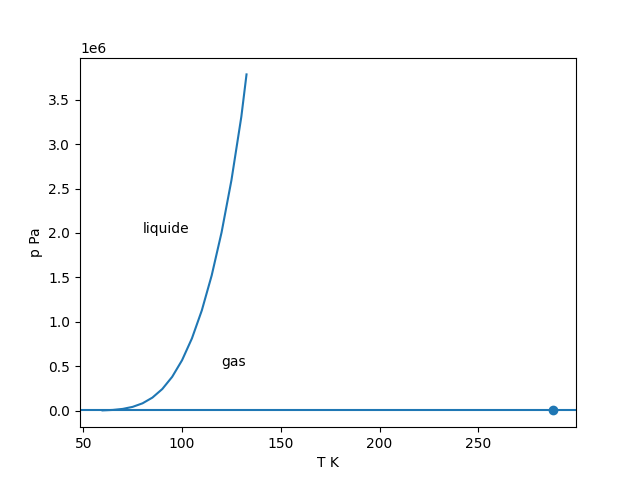

['mesh',None,[2 sons],'CGNSTree_t']
   |_['CGNSLibraryVersion',array([4.0],dtype='float32'),[0 son],'CGNSLibraryVersion_t']
   |_['Base',array(shape=(2,),dtype='int32',order='F'),[1 son],'CGNSBase_t']
       |_['zone',array(shape=(2, 3),dtype='int32',order='F'),[4 sons],'Zone_t']
           |_['ZoneType',array('b'Structured'',dtype='|S1'),[0 son],'ZoneType_t']
           |_['GridCoordinates',None,[3 sons],'GridCoordinates_t']
           |   |_['CoordinateX',array(shape=(1000, 150),dtype='float64',order='F'),[0 son],'DataArray_t']
           |   |_['CoordinateY',array(shape=(1000, 150),dtype='float64',order='F'),[0 son],'DataArray_t']
           |   |_['CoordinateZ',array(shape=(1000, 150),dtype='float64',order='F'),[0 son],'DataArray_t']
           |_['FlowSolution#Centers',None,[6 sons],'FlowSolution_t']
           |   |_['GridLocation',array('b'CellCenter'',dtype='|S1'),[0 son],'GridLocation_t']
           |   |_['Density',array(shape=(999, 149),dtype='float64',order='F'),[0 son],'Da

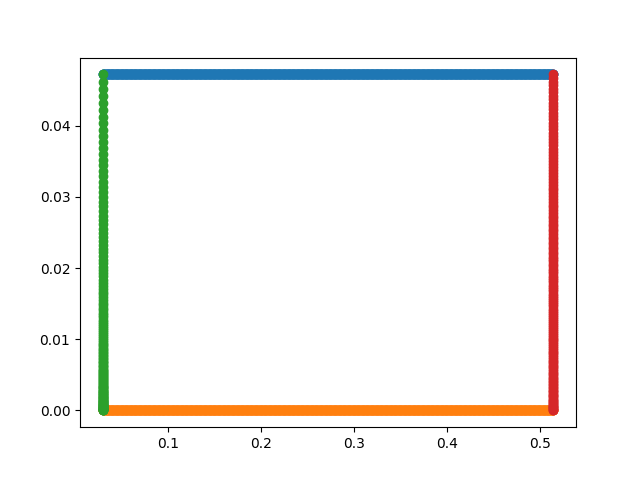

In [29]:
# Generate a mesh file name using various input parameters
real_nb_pts = np.shape(I.getValue(I.getNodeByName(mesh, "CoordinateX")))
mesh_name = "FP_Ma_{:2.1f}_Re_m_{:2.1f}e6_Ni_{:d}_Nj_{:d}.cgns".format(Mach, Re_m / 1e6, real_nb_pts[0], real_nb_pts[1])

######################################
# Set up the uniform solution for flow field
######################################
r_gp = 287.058  # Specific gas constant in J/(kg·K)
Cv = r_gp / (gamma - 1)  # Specific heat at constant volume
Ti = T_inf * (1 + (gamma - 1) / 2 * Mach**2) ** (-1)  # Ambient temperature using the Mach number
mu_inf = sutherland(T_inf)  # Dynamic viscosity at the free-stream temperature
U_inf = Mach * (gamma * r_gp * T_inf) ** (0.5)  # Free-stream velocity
rho_inf = Re_m * mu_inf / U_inf  # Free-stream density using Reynolds number

# Momentum and energy terms at free-stream conditions
momX_inf = rho_inf * U_inf
momY_inf = 0  # No momentum in the Y direction (2D assumption)
momZ_inf = 0  # No momentum in the Z direction (2D assumption)
EnergyStagnationDensity_inf = rho_inf * Cv * T_inf + 0.5 * rho_inf * U_inf**2
p_inf = rho_inf * U_inf**2  # Pressure at free-stream conditions

# Initialize arrays for the solution (one array for each flow variable)
one = np.ones((real_nb_pts[0] - 1, real_nb_pts[1] - 1), order="F")  # Array of ones for initializing

initialsol_momX = momX_inf * one
initialsol_momY = momY_inf * one
initialsol_momZ = momZ_inf * one
initialsol_rho = rho_inf * one
initialsol_rhoE = EnergyStagnationDensity_inf * one
print('Tinf = ', T_inf, ' Ti = ', Ti, ' Tinf/Ti = ', T_inf/Ti)
print('rhoinf = ', rho_inf)
print('p_inf = ', rho_inf*r_gp*T_inf)
print('V_inf = ', U_inf)
print('rhoE inf = ', EnergyStagnationDensity_inf)

# Check if air is still gaseous
T_limit = np.array([59.75, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120,125, 130, 132.63])
p_limit = np.array([0.02432, 0.07756, 0.19431, 0.42282, 0.82321, 1.4665, 2.4320, 3.8047, 5.6742, 8.1341, 11.282, 15.223, 20.067, 25.949, 33.084, 37.858])*1e5

fig, axe = plt.subplots()
axe.plot(T_limit, p_limit)
axe.scatter(T_inf, rho_inf*r_gp*T_inf)
axe.axhline(p_limit[0])
axe.text(80, 2e6, 'liquide')
axe.text(120, 0.5e6, 'gas')
axe.set_xlabel('T K')
axe.set_ylabel('p Pa')
plt.show(block = False)

######################################
# Create a PyTree for the flow solution
######################################
zone = I.getNodeByName(mesh, "zone")  # Get the zone (mesh)
flow = I.newFlowSolution(
    name="FlowSolution#Centers", gridLocation="CellCenter", parent=zone
)

# Add the flow variables (density, momentum, and energy) to the solution
I.newDataArray("Density", value=initialsol_rho, parent=flow)
I.newDataArray("MomentumX", value=initialsol_momX, parent=flow)
I.newDataArray("MomentumY", value=initialsol_momY, parent=flow)
I.newDataArray("MomentumZ", value=initialsol_momZ, parent=flow)
I.newDataArray("EnergyStagnationDensity", value=initialsol_rhoE, parent=flow)

# Set reference state variables (used for CFD calculations and comparisons)
ref = I.newReferenceState(name="ReferenceState", parent=zone)
I.newDataArray("Cv_ref", value=Cv, parent=ref)
I.newDataArray("Density_ref", value=rho_inf, parent=ref)
I.newDataArray("DynamicViscosity_ref", value=mu_inf, parent=ref)
I.newDataArray("EnergyStagnation_ref", value=EnergyStagnationDensity_inf, parent=ref)
I.newDataArray("Length_ref", value=1 / Re_m, parent=ref)  # Sphere radius for Reynolds calculation
# I.newDataArray("Rn", value=Rn, parent=ref)  # Sphere radius
I.newDataArray("Mach", value=Mach, parent=ref)  # Mach number
I.newDataArray("Pressure_ref", value=p_inf, parent=ref)  # Reference pressure
I.newDataArray("Reynolds_unit", value=Re_m, parent=ref)  # Reynolds number (unit)
I.newDataArray("V_ref", value=U_inf, parent=ref)  # Reference velocity
I.newDataArray("Momentum_ref", value=momX_inf, parent=ref)  # Reference momentum in X direction

# Print the final tree of the mesh
I.printTree(mesh)

# Save the PyTree structure to a file in CGNS format
# C.convertPyTree2File(mesh, os.path.join(workdir, mesh_name))
print(mesh_name)  # Output the name of the mesh file

# Plot the coordinates of the mesh and boundary points
CoordX = I.getValue(I.getNodeFromName(mesh, "CoordinateX"))
CoordY = I.getValue(I.getNodeFromName(mesh, "CoordinateY"))
fig, axe = plt.subplots()  # Create a figure for plotting
axe.scatter(CoordX[:, -1], CoordY[:, -1], label="Jhi")  # High boundary of J (Y)
axe.scatter(CoordX[:, 0], CoordY[:, 0], label="Jlo")   # Low boundary of J (Y)
axe.scatter(CoordX[0, :], CoordY[0, :], label="Ilo")   # Low boundary of I (X)
axe.scatter(CoordX[-1, :], CoordY[-1, :], label="Ihi") # High boundary of I (X)




In [30]:
x0 = I.getValue(I.getNodeByName(mesh, 'CoordinateX'))
y0 = I.getValue(I.getNodeByName(mesh, 'CoordinateY'))
gh = 0
Lref = 1
mach = Mach
Ma = Mach
Re= Re_m
dphys =  dict()
dphys['gam']      = 1.4       # Gamma constant
dphys['Ts']       = 273.15    # Sutherland ref temp
dphys['cs']       = 110.4     # Sutherland constant (temp
dphys['musuth']   = 1.715e-5  # Sutherland ref dynamic viscosity
dphys['rgaz']     = 287.056     # Air ideal gas constant
dphys['Prandtl']  = 0.72      # Prandtl number
dphys['Tinf']     = T_inf      # Freestream temperature
dphys['Twall']    = 300.0     # Wall temperature for isothermal BC
dphys['rho0']     = rho_inf  # Freestream density
dphys['Lref']     = 1.0       # Reference length
dphys['Mach']     = Ma       # Freestream Mach number
dphys['Runit']    = Re 	    # Reynolds number per meter
dphys['Rref']     = dphys['Runit'] * dphys['Lref'] # Freestream Reynolds number
dphys['T0']       = dphys['Ts']*(1.0+(dphys['gam']-1.0)/(2.0)*dphys['Mach']**2.0) #Total temperature from isentropic relation 
dphys['mu0'] = dphys['musuth']*np.sqrt(dphys['Ts']/dphys['Ts'] )*((1.+dphys['cs']/dphys['Ts'] )/(1.+dphys['cs']/dphys['Ts']))

# rhoinf = 1.0, uinf = 1.0, einf = 0.588183421516755

print('Self similar BL')
import SIM.BLprofiles_implicit as blsim

road, uad, vad, Ead = blsim.BLprofile(x0[:, gh:]*Lref, y0[:, gh:]*Lref, mach, dphys, isplot=False, damped=False)

# road = bu.centers_array(road)
# uad  = bu.centers_array(uad)
# vad  = bu.centers_array(vad)
# Ead  = bu.centers_array(Ead)

road_c = ((road[:-1, :-1] + road[1:, :-1]) + (road[:-1, 1:]+road[1:, 1:]))/4
uad_c  = ((uad[:-1, :-1] + uad[1:, :-1]) + (uad[:-1, 1:]+uad[1:, 1:]))/4
vad_c  = ((vad[:-1, :-1] + vad[1:, :-1]) + (vad[:-1, 1:]+vad[1:, 1:]))/4
Ead_c  = ((Ead[:-1, :-1] + Ead[1:, :-1]) + (Ead[:-1, 1:]+Ead[1:, 1:]))/4


# w[:, gh:, 0]     = road[:,:]          * rhoinf
# w[:, gh:, 1]     = road[:,:]*uad[:,:] * rhoinf * uinf
# w[:, gh:, 2]     = road[:,:]*vad[:,:] * rhoinf * uinf
# w[:, gh:, 4]     = road[:,:]*Ead[:,:] * rhoinf * einf

Self similar BL


Tinf =  288  Ti =  57.02970297029704  Tinf/Ti =  5.049999999999999
rhoinf =  0.039698584364416784
p_inf =  3281.989314378457
V_inf =  1530.9379995283937
rhoE inf =  54727.17181726077


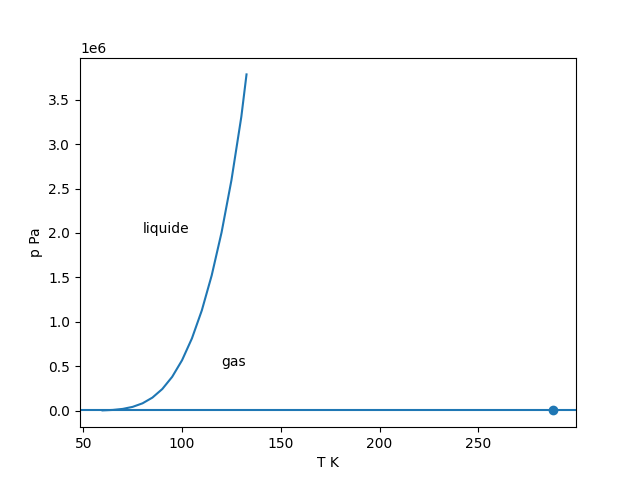

['mesh',None,[2 sons],'CGNSTree_t']
   |_['CGNSLibraryVersion',array([4.0],dtype='float32'),[0 son],'CGNSLibraryVersion_t']
   |_['Base',array(shape=(2,),dtype='int32',order='F'),[1 son],'CGNSBase_t']
       |_['zone',array(shape=(2, 3),dtype='int32',order='F'),[4 sons],'Zone_t']
           |_['ZoneType',array('b'Structured'',dtype='|S1'),[0 son],'ZoneType_t']
           |_['GridCoordinates',None,[3 sons],'GridCoordinates_t']
           |   |_['CoordinateX',array(shape=(1000, 150),dtype='float64',order='F'),[0 son],'DataArray_t']
           |   |_['CoordinateY',array(shape=(1000, 150),dtype='float64',order='F'),[0 son],'DataArray_t']
           |   |_['CoordinateZ',array(shape=(1000, 150),dtype='float64',order='F'),[0 son],'DataArray_t']
           |_['FlowSolution#Centers',None,[6 sons],'FlowSolution_t']
           |   |_['GridLocation',array('b'CellCenter'',dtype='|S1'),[0 son],'GridLocation_t']
           |   |_['Density',array(shape=(999, 149),dtype='float64',order='F'),[0 son],'Da

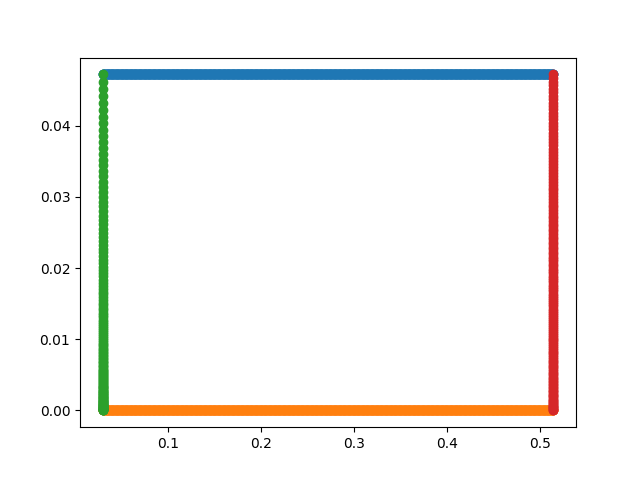

In [31]:
# Generate a mesh file name using various input parameters
real_nb_pts = np.shape(I.getValue(I.getNodeByName(mesh, "CoordinateX")))
mesh_name = "FP_Ma_{:2.1f}_Re_m_{:2.1f}e6_Ni_{:d}_Nj_{:d}.cgns".format(Mach, Re_m / 1e6, real_nb_pts[0], real_nb_pts[1])

######################################
# Set up the uniform solution for flow field
######################################
r_gp = 287.058  # Specific gas constant in J/(kg·K)
Cv = r_gp / (gamma - 1)  # Specific heat at constant volume
Ti = T_inf * (1 + (gamma - 1) / 2 * Mach**2) ** (-1)  # Ambient temperature using the Mach number
mu_inf = sutherland(T_inf)  # Dynamic viscosity at the free-stream temperature
U_inf = Mach * (gamma * r_gp * T_inf) ** (0.5)  # Free-stream velocity
rho_inf = Re_m * mu_inf / U_inf  # Free-stream density using Reynolds number

# Momentum and energy terms at free-stream conditions
momX_inf = rho_inf * U_inf
momY_inf = 0  # No momentum in the Y direction (2D assumption)
momZ_inf = 0  # No momentum in the Z direction (2D assumption)
EnergyStagnationDensity_inf = rho_inf * Cv * T_inf + 0.5 * rho_inf * U_inf**2
p_inf = rho_inf * U_inf**2  # Pressure at free-stream conditions

# Initialize arrays for the solution (one array for each flow variable)
one = np.ones((real_nb_pts[0]-1, real_nb_pts[1]-1), order="F")  # Array of ones for initializing

initialsol_rho = rho_inf * road[:-1,:-1]  
initialsol_momX = momX_inf * road[:-1,:-1]*uad[:-1,:-1]  
initialsol_momY = momX_inf * road[:-1,:-1]*vad[:-1,:-1]  
initialsol_momZ = momZ_inf * one
initialsol_rhoE = EnergyStagnationDensity_inf * road[:-1,:-1]*Ead[:-1,:-1]  
print('Tinf = ', T_inf, ' Ti = ', Ti, ' Tinf/Ti = ', T_inf/Ti)
print('rhoinf = ', rho_inf)
print('p_inf = ', rho_inf*r_gp*T_inf)
print('V_inf = ', U_inf)
print('rhoE inf = ', EnergyStagnationDensity_inf)

# Check if air is still gaseous
T_limit = np.array([59.75, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120,125, 130, 132.63])
p_limit = np.array([0.02432, 0.07756, 0.19431, 0.42282, 0.82321, 1.4665, 2.4320, 3.8047, 5.6742, 8.1341, 11.282, 15.223, 20.067, 25.949, 33.084, 37.858])*1e5

fig, axe = plt.subplots()
axe.plot(T_limit, p_limit)
axe.scatter(T_inf, rho_inf*r_gp*T_inf)
axe.axhline(p_limit[0])
axe.text(80, 2e6, 'liquide')
axe.text(120, 0.5e6, 'gas')
axe.set_xlabel('T K')
axe.set_ylabel('p Pa')
plt.show(block = False)

######################################
# Create a PyTree for the flow solution
######################################
zone = I.getNodeByName(mesh, "zone")  # Get the zone (mesh)
flow = I.newFlowSolution(
    name="FlowSolution#Centers", gridLocation="CellCenter", parent=zone
)

# Add the flow variables (density, momentum, and energy) to the solution
I.newDataArray("Density", value=initialsol_rho, parent=flow)
I.newDataArray("MomentumX", value=initialsol_momX, parent=flow)
I.newDataArray("MomentumY", value=initialsol_momY, parent=flow)
I.newDataArray("MomentumZ", value=initialsol_momZ, parent=flow)
I.newDataArray("EnergyStagnationDensity", value=initialsol_rhoE, parent=flow)

# Set reference state variables (used for CFD calculations and comparisons)
ref = I.newReferenceState(name="ReferenceState", parent=zone)
I.newDataArray("Cv_ref", value=Cv, parent=ref)
I.newDataArray("Density_ref", value=rho_inf, parent=ref)
I.newDataArray("DynamicViscosity_ref", value=mu_inf, parent=ref)
I.newDataArray("EnergyStagnation_ref", value=EnergyStagnationDensity_inf, parent=ref)
I.newDataArray("Length_ref", value=1 / Re_m, parent=ref)  # Sphere radius for Reynolds calculation
# I.newDataArray("Rn", value=Rn, parent=ref)  # Sphere radius
I.newDataArray("Mach", value=Mach, parent=ref)  # Mach number
I.newDataArray("Pressure_ref", value=p_inf, parent=ref)  # Reference pressure
I.newDataArray("Reynolds_unit", value=Re_m, parent=ref)  # Reynolds number (unit)
I.newDataArray("V_ref", value=U_inf, parent=ref)  # Reference velocity
I.newDataArray("Momentum_ref", value=momX_inf, parent=ref)  # Reference momentum in X direction

# Print the final tree of the mesh
I.printTree(mesh)

# Save the PyTree structure to a file in CGNS format
if saving:
    save_name =  mesh_name.replace('.cgns', '_' + additional_name + '.cgns')
    C.convertPyTree2File(mesh, os.path.join(workdir,save_name))
print(save_name)  # Output the name of the mesh file

# Plot the coordinates of the mesh and boundary points
CoordX = I.getValue(I.getNodeFromName(mesh, "CoordinateX"))
CoordY = I.getValue(I.getNodeFromName(mesh, "CoordinateY"))
fig, axe = plt.subplots()  # Create a figure for plotting
axe.scatter(CoordX[:, -1], CoordY[:, -1], label="Jhi")  # High boundary of J (Y)
axe.scatter(CoordX[:, 0], CoordY[:, 0], label="Jlo")   # Low boundary of J (Y)
axe.scatter(CoordX[0, :], CoordY[0, :], label="Ilo")   # Low boundary of I (X)
axe.scatter(CoordX[-1, :], CoordY[-1, :], label="Ihi") # High boundary of I (X)




In [32]:
t_base = C.convertFile2PyTree(os.path.join(workdir, save_name))
# t_base = C.node2Center(t_base)
names = ["Density", "MomentumX", "MomentumY", "MomentumZ", "EnergyStagnationDensity"]
grid_x_in_2D = I.getValue(I.getNodeFromName(t_base, "CoordinateX"))
grid_y_in_2D = I.getValue(I.getNodeFromName(t_base, "CoordinateY"))
#Wall coordinates is x,y base
X_wall_node_in = grid_x_in_2D[:-1,0]
Y_wall_node_in = grid_y_in_2D[:-1,0]
X_wall_in = (X_wall_node_in[1:]+X_wall_node_in[:-1])/2
Y_wall_in = (Y_wall_node_in[1:]+Y_wall_node_in[:-1])/2

def compute_prim_bf(bf, gam=1.4, r_gas=287.15):
    
    bfp = np.zeros(bf.shape, dtype=np.float64)
    #primitives (rho u T)
    bft = np.zeros(bf.shape, dtype=np.float64)

    bfp[0] = bf[0]
    bfp[1:4] = bf[1:4]/bf[0]
    
    bft = np.copy(bfp)
    
    bfp[-1] = (gam-1.0) * (bf[-1]-0.5*(np.sum(bf[1:4]**2, axis=0))/bf[0])

    
    bft[-1] = bfp[-1] / (r_gas * bft[0])

    # T =  (gam-1.0)*(bf[-1]-0.5*(np.sum(bf[1:4]**2, axis=0))/bf[0])/(r_gas*bf[0])
    # print('bfp[-1]-T=', norm(bfp[-1]-T))
    # print('bft[-1]-T=', norm(bft[-1]-T))
    
    return bfp, bft
def comp_Sutherland(propref, Ts, Cs, T):
    '''Dynamical viscosity / thermal conductivity from sutherland law'''
    return propref*np.sqrt(T/Ts)*((1.+Cs/Ts)/(1.+Cs/T))
im_in, jm_in = np.shape(grid_x_in_2D)
print(f'{im_in = }, {jm_in = }')
bf_in = np.zeros((im_in-1, jm_in-1, 5))

for i in range(5):
    print(np.shape(I.getValue(I.getNodeFromName(t_base, names[i]))), np.shape(bf_in[:,:,i]))
    bf_in[:,:,i] = I.getValue(I.getNodeFromName(t_base, names[i]))
bf_in = np.moveaxis(bf_in, (0,1,2), (1,2,0))
bfp_in, bft_in = compute_prim_bf(bf_in, dphys['gam'],dphys['rgaz'])

mu = comp_Sutherland(dphys['musuth'], dphys['Ts'], dphys['cs'], bft_in[4,:,:])
print('rho inf = {}, MumX inf = {}, MumY inf = {}, Estag inf = {}'.format(bf_in[0,0,-1], bf_in[1,0,-1], bf_in[2,0,-1], bf_in[4,0,-1]))
print('rho inf = {}, Vx inf = {}, Vy inf = {}, T inf = {}'.format(bft_in[0,0,-1], bft_in[1,0,-1], bft_in[2,0,-1], bft_in[4,0,-1]))

ds_j_wall_in = ((grid_x_in_2D[:-1, 1]-X_wall_node_in)**2+(grid_y_in_2D[:-1, 1]-Y_wall_node_in)**2)**(0.5)
ds_j_wall_in = ((grid_y_in_2D[:-1, 1]-grid_y_in_2D[:-1, 0])**2)**(0.5)
V_in = (bft_in[1,:,:]**2+bft_in[2,:,:]**2)**0.5


tau_wall = mu[:,0]*(V_in[:,1]-0)/ds_j_wall_in
tau_wall = mu[:,0]*(V_in[:,2]-0)/(grid_y_in_2D[:-1, 2]-grid_y_in_2D[:-1, 0])
U_tau = (tau_wall/bft_in[0,:,0])**(0.5)
y_plus_1st_cell = U_tau*ds_j_wall_in*bft_in[0,:,0]/mu[:,0]



euclid_len = lambda x,y: np.sqrt(x**2+ y**2)
print('\nFor input mesh')
print(f'At cell  0 point \t: y+ = {y_plus_1st_cell[0]}, \tU_tau = {U_tau[0]}, \ttau_wall = {tau_wall[0]}, ds_j = {ds_j_wall_in[0]}')
print(f'At cell 50 point \t: y+ = {y_plus_1st_cell[50]}, \tU_tau = {U_tau[50]}, \ttau_wall = {tau_wall[50]}, ds_j = {ds_j_wall_in[-1]}')
print(f'At end \t\t\t: y+ = {y_plus_1st_cell[-1]}, \tU_tau = {U_tau[-1]}, \ttau_wall = {tau_wall[-1]}, ds_j = {ds_j_wall_in[-1]}')


Reading FP_Ma_4.5_Re_m_3.4e6_Ni_1000_Nj_150_TM_v2.cgns (bin_hdf)...done.
im_in = 1000, jm_in = 150
(999, 149) (999, 149)
(999, 149) (999, 149)
(999, 149) (999, 149)
(999, 149) (999, 149)
(999, 149) (999, 149)
rho inf = 0.03969843620394491, MumX inf = 60.77581644331629, MumY inf = 0.19965825161505266, Estag inf = 54727.098678034796
rho inf = 0.03969843620394491, Vx inf = 1530.937292620027, Vy inf = 5.029373212318429, T inf = 287.99049326011783

For input mesh
At cell  0 point 	: y+ = 0.48031446540931194, 	U_tau = 73.29933367141038, 	tau_wall = 48.19396254675406, ds_j = 3.497283183753167e-05
At cell 50 point 	: y+ = 0.4330674249292571, 	U_tau = 60.4849580004001, 	tau_wall = 32.816128925673304, ds_j = 9.965038171876778e-05
At end 			: y+ = 0.3988266015522947, 	U_tau = 21.36044574781533, 	tau_wall = 4.092731037053562, ds_j = 9.965038171876778e-05
